In [1]:
import os
import pathlib
import time
import datetime

from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import json
import random
import csv
import concurrent.futures
from multiprocessing import freeze_support

from keras import layers
from keras import models
from keras import mixed_precision

seed = 6969
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
pre_segment_size = 12
post_segment_size = 12
prediction_size = 8
segment_size = pre_segment_size + post_segment_size + prediction_size

note_size = 49

input_shape = (segment_size, note_size)

batch_size = 256

replays_simple_dir = pathlib.Path("decoded-replays")
replays_dir = replays_simple_dir
leaderboards_dir = pathlib.Path("leaderboards")
maps_dir = pathlib.Path("maps")
speed_stuff = False

In [3]:
def get_leaderboard_replays(percentage=100, split=20):

    leaderboard_ids = np.array(tf.io.gfile.listdir(str(replays_dir)))
    random.shuffle(leaderboard_ids)
    leaderboard_ids = leaderboard_ids[:int(len(leaderboard_ids)*percentage/100)]
    val_leaderboard_ids = leaderboard_ids[:int(len(leaderboard_ids)*split/100)]
    val_leaderboard_ids
    # val_leaderboard_ids = []

    train_data = []
    val_data = []
    for leaderboard_id in leaderboard_ids:
        if leaderboard_id == "219625":
            continue
        
        if leaderboard_id in val_leaderboard_ids:
            val_data.append(leaderboard_id)
        else:
            train_data.append(leaderboard_id)

    return train_data, val_data


def read_json_file(file):
    try:
        with open(file, "r", encoding="utf8", errors="ignore") as f:
            file_content = f.read()
            if len(file_content) < 100:
                return None
            json_content = json.loads(file_content)
            return json_content
    except (KeyboardInterrupt, SystemExit):
        raise
    except Exception as e:
        print(e)
        print(file)
        raise


def get_replay_notes(replay, njs, time_scale):
    notes = []

    prev_zero_note_time = 0
    prev_one_note_time = 0
    # for note_info, score, note_time in sorted(replay, key=lambda item: item[2]):

    for note_time, note_info, prediction in replay:
        type = note_info[-1]
        score, speed = prediction

        # TODO: use map data for note positions and timings to not have to exclude misses (misses are registered much later, which messes up the timings)
        if score < 0:
            continue

        # NOTE: 0-100 score range is rare and often happens for tracking problems that are not important here
        # would be good to replace this with acc component only and potentially learn all both acc and swing angles
        # but need different format replay files for that
        # score = max(0, score - 100)

        delta_to_zero = note_time - prev_zero_note_time
        delta_to_one = note_time - prev_one_note_time

        if delta_to_zero < 0 or delta_to_one < 0:
            print(f"{delta_to_zero} {delta_to_one}")

        if type == "0":
            prev_zero_note_time = note_time
            note = preprocess_note(prediction, delta_to_zero,
                                   delta_to_one, note_info, njs, time_scale)
            notes.append(note)
        if type == "1":
            prev_one_note_time = note_time
            note = preprocess_note(prediction, delta_to_one,
                                   delta_to_zero, note_info, njs, time_scale)
            notes.append(note)

    return notes


def preprocess_note(prediction, delta, delta_other, note_info, njs, time_scale):
    # NOTE: timing increases difficulty not linearly and caps out at ~2 seconds
    # no idea if such parameters can be learned by neural networks without adding scaling like I did right here
    # delta = int(delta*1000)/1000
    # delta_other = int(delta_other*1000)/1000

    # NOTE: timing increases difficulty not linearly and caps out at ~2 seconds
    # no idea if such parameters can be learned by neural networks without adding scaling like I did right here
    delta = delta/time_scale
    delta_other = delta_other/time_scale
    njs = njs*time_scale
    
    delta_long = max(0, 2 - delta)/2
    delta_other_long = max(0, 2 - delta_other)/2
    delta_short = max(0, 0.5 - delta)*2
    delta_other_short = max(0, 0.5 - delta_other)*2

    col_number = int(note_info[0])
    row_number = int(note_info[1])
    direction_number = int(note_info[2])
    color = int(note_info[3])

    row_col = [0] * 4 * 3
    direction = [0] * 10
    
    row_col2 = [0] * 4 * 3
    direction2 = [0] * 10
    
    row_col[col_number * 3 + row_number] = 1
    direction[direction_number] = 1

    # color_arr = [0] * 2
    # color_arr[color] = 1

    response = []

    if color == 0:
        response.extend(row_col)
        response.extend(direction)
        response.extend(row_col2)
        response.extend(direction2)
        response.extend([
            delta_short,
            delta_long,
        ])
        response.extend([
            delta_other_short,
            delta_other_long,
        ])
    if color == 1:
        response.extend(row_col2)
        response.extend(direction2)
        response.extend(row_col)
        response.extend(direction)
        response.extend([
            delta_other_short,
            delta_other_long,
        ])
        response.extend([
            delta_short,
            delta_long,
        ])
        
    # response.extend(row_col)
    # response.extend(direction)
    # response.extend(color_arr)

    response.extend([
        njs/30,
        prediction
    ])

    return response
# print(len(preprocess_note(0.5, 0.5, 0.5, "0000", 0.5, 1)))

def create_segments(notes):
    empty_res = ([], [])
    if len(notes) < prediction_size:
        return empty_res

    segments = []
    predictions = []
    for i in range(len(notes)-prediction_size+1):
        if i % prediction_size != 0:
            continue
                
        pre_slice = notes[max(0, i-pre_segment_size):i]
        slice = notes[i:i+prediction_size]
        post_slice = notes[i+prediction_size:i+prediction_size+post_segment_size]

        # NOTE: using relative score can be good to find relative difficulty of the notes more fairly
        # because good players will always get higher acc and worse players will do badly even on easy patterns

        pre_segment = [np.array(note[:-1]) for note in pre_slice]
        if len(pre_segment) < pre_segment_size:
            pre_segment[0:0] = [np.zeros(note_size, dtype=np.float32) for i in range(pre_segment_size - len(pre_segment))]
            
        segment = [np.array(note[:-1]) for note in slice]

        post_segment = [np.array(note[:-1]) for note in post_slice]
        if len(post_segment) < post_segment_size:
            post_segment.extend([np.zeros(note_size, dtype=np.float32) for i in range(post_segment_size - len(post_segment))])


        # fix this pls
        prediction = [note[-1][1] if speed_stuff else note[-1][0] for note in slice]

        final_segment = []
        final_segment.extend(pre_segment)
        final_segment.extend(segment)
        final_segment.extend(post_segment)
        segments.append(final_segment)
        
        predictions.append(prediction)

    return segments, predictions


def get_replays_for_leaderboard(leaderboard_id):
    for replay_file in glob.glob(f'{replays_dir}/{leaderboard_id}/*.dat.json'):
        replay = read_json_file(replay_file)
        if replay is None or replay["info"]["st"] != 0 or replay["info"]["leftHanded"]:
            continue
        replay["fileName"] = replay_file
        yield replay
        
        
def get_leaderboard_data(leaderboard_id, minPlays):
    leaderboard_info_file = f'{replays_simple_dir}/{leaderboard_id}/leaderboard-info.json'

    leaderboard_info = read_json_file(leaderboard_info_file)
    beatsaver_key = leaderboard_info["info"]["beatsaverKey"]
    difficulty = leaderboard_info["info"]["difficulty"]["difficulty"]
    number_of_plays = leaderboard_info["info"]["plays"]
    
    if number_of_plays < minPlays:
        raise Exception()
    
    map_path = f'{maps_dir}/{beatsaver_key}'
    if not os.path.isfile(map_path):
        # Download map zip from BeatSaver
        import zipfile
        import io
        import requests

        url = f"https://beatsaver.com/api/maps/id/{beatsaver_key}"
        data = json.loads(requests.get(url).text)
        map_link = data["versions"][0]["downloadURL"]

        r = requests.get(map_link)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(map_path)
    
    map_info_file = glob.glob(f'{map_path}/*nfo.dat')[0]

    with open(map_info_file, "r", encoding="utf8", errors="ignore") as f:
        file_content = f.read()
        map_info = json.loads(file_content)
        bpm = map_info["_beatsPerMinute"]
        time_scale = 60/bpm

        for beatmap_set in map_info["_difficultyBeatmapSets"]:
            if beatmap_set["_beatmapCharacteristicName"] != "Standard":
                continue

            for beatmap in beatmap_set["_difficultyBeatmaps"]:
                if beatmap["_difficultyRank"] == difficulty:
                    njs = float(beatmap["_noteJumpMovementSpeed"])
                    map_file_name = beatmap["_beatmapFilename"]
                    with open(map_info_file.replace("Info.dat", map_file_name).replace("info.dat", map_file_name), "r", encoding="utf8", errors="ignore") as map_file:
                        map_file_content = map_file.read()
                        map_file_json = json.loads(map_file_content)
                        map_notes = sorted(list(map(lambda n: (n["_time"]*time_scale, f"{n['_lineIndex']}{n['_lineLayer']}{n['_cutDirection']}{n['_type']}"), filter(lambda n: n['_type'] == 1 or n['_type'] == 0, map_file_json["_notes"]))), key=lambda x: (x[0], x[1]))

    replays = get_replays_for_leaderboard(leaderboard_id)

    data = [njs, number_of_plays]

    return data, map_notes, replays


def get_replay_speeds(angleFrames, noteTimes, movingAverageTime):
    angleFramesIter = 0
    
    replay_note_saber_speeds = [[] for _ in noteTimes]
    
    for index, noteTime in sorted(enumerate(noteTimes), key=lambda x: x[1]):
        while noteTime > angleFrames[angleFramesIter][0]:
            angleFramesIter += 1
        
        lastAngleRight = (angleFrames[angleFramesIter][1])/(angleFrames[angleFramesIter][0] - angleFrames[angleFramesIter - 1][0])*(noteTime-angleFrames[angleFramesIter - 1][0])
        lastAngleLeft = (angleFrames[angleFramesIter][2])/(angleFrames[angleFramesIter][0] - angleFrames[angleFramesIter - 1][0])*(noteTime-angleFrames[angleFramesIter - 1][0])

        reverseAngleFramesIter = 1
        currNoteTime = noteTime - movingAverageTime
        while True:
            currIter = angleFramesIter-reverseAngleFramesIter
            if angleFrames[currIter][0] < currNoteTime:
                firstAngleRight = (angleFrames[currIter+1][1])/(angleFrames[currIter+1][0] - angleFrames[currIter][0])*(angleFrames[currIter+1][0] - (currNoteTime))
                firstAngleLeft = (angleFrames[currIter+1][2])/(angleFrames[currIter+1][0] - angleFrames[currIter][0])*(angleFrames[currIter+1][0] - (currNoteTime))
                break
            else:
                reverseAngleFramesIter += 1
        
        totalAngleRight = firstAngleRight + lastAngleRight
        totalAngleLeft = firstAngleLeft + lastAngleLeft
        for frameTime, angleRight, angleLeft in angleFrames[currIter+2:angleFramesIter]:
            totalAngleRight += angleRight
            totalAngleLeft += angleLeft

        angleSpeedRight = totalAngleRight/movingAverageTime
        angleSpeedLeft = totalAngleLeft/movingAverageTime
        
        replay_note_saber_speeds[index] = [angleSpeedRight, angleSpeedLeft]
    
    rights = [v[0] for v in replay_note_saber_speeds]
    lefts = [v[1] for v in replay_note_saber_speeds]
    print(sum(rights)/len(rights), sum(lefts)/len(lefts))
    
    return replay_note_saber_speeds


def get_replay_accelerations(angleFrames, noteTimes, movingAverageTime):
    angle_speeds = []
    for i, [time, right, left] in enumerate(angleFrames):
        if i < 1:
            continue
        prev_time, prev_right, prev_left = angleFrames[i-1]
        if time-prev_time == 0:
            continue
        t_d = time - prev_time
        right_d = abs(right - prev_right)
        left_d = abs(left - prev_left)
        angle_speeds.append([time, right_d/t_d, left_d/t_d])
    
    angle_accelerations = []
    for i, [time, right, left] in enumerate(angle_speeds):
        if i < 1:
            continue
        prev_time, prev_right, prev_left = angle_speeds[i-1]
        if time-prev_time == 0:
            continue
        t_d = time - prev_time
        right_d = abs(right - prev_right)
        left_d = abs(left - prev_left)
        angle_accelerations.append([time, right_d/t_d, left_d/t_d])

    angleFrames = angle_accelerations
    angleFramesIter = 0
    
    replay_note_saber_speeds = [[] for _ in noteTimes]
    
    for index, noteTime in sorted(enumerate(noteTimes), key=lambda x: x[1]):
        while noteTime > angleFrames[angleFramesIter][0]:
            angleFramesIter += 1
        
        lastAngleRight = (angleFrames[angleFramesIter][1])/(angleFrames[angleFramesIter][0] - angleFrames[angleFramesIter - 1][0])*(noteTime-angleFrames[angleFramesIter - 1][0])
        lastAngleLeft = (angleFrames[angleFramesIter][2])/(angleFrames[angleFramesIter][0] - angleFrames[angleFramesIter - 1][0])*(noteTime-angleFrames[angleFramesIter - 1][0])

        reverseAngleFramesIter = 1
        currNoteTime = noteTime - movingAverageTime
        while True:
            currIter = angleFramesIter-reverseAngleFramesIter
            if angleFrames[currIter][0] < currNoteTime:
                firstAngleRight = (angleFrames[currIter+1][1])/(angleFrames[currIter+1][0] - angleFrames[currIter][0])*(angleFrames[currIter+1][0] - (currNoteTime))
                firstAngleLeft = (angleFrames[currIter+1][2])/(angleFrames[currIter+1][0] - angleFrames[currIter][0])*(angleFrames[currIter+1][0] - (currNoteTime))
                break
            else:
                reverseAngleFramesIter += 1
        
        totalAngleRight = firstAngleRight + lastAngleRight
        totalAngleLeft = firstAngleLeft + lastAngleLeft
        items = 2
        for frameTime, angleRight, angleLeft in angleFrames[currIter+2:angleFramesIter]:
            items += 1
            totalAngleRight += angleRight
            totalAngleLeft += angleLeft

        angleSpeedRight = totalAngleRight/items
        angleSpeedLeft = totalAngleLeft/items
        
        replay_note_saber_speeds[index] = [angleSpeedRight, angleSpeedLeft]
           
    rights = [v[0] for v in replay_note_saber_speeds]
    lefts = [v[1] for v in replay_note_saber_speeds]
    print(sum(rights)/len(rights), sum(lefts)/len(lefts))
    print()
        
    return replay_note_saber_speeds


def get_replay_total_score(replay):
    return sum([max(1-1/0.3*s, 0) for s, s1, s2 in replay["scores"]])


def get_sorted_filtered_replays(replays):
    highest_total_score = -1
    for total_score, replay in sorted([(get_replay_total_score(replay), replay) for replay in replays], key=lambda x: x[0], reverse=True):
        if highest_total_score == -1:
            highest_total_score = total_score
        if total_score/highest_total_score > 0.94:
            yield replay


def preprocess_leaderboard_replays(leaderboard_id, skip_replays=False, time_scale=1):
    count = 0
    skip = False
    min_map_plays = 400
    # empty_res = []
    empty_res = ([], [])
    
    try:
        map_data, map_notes, replays = get_leaderboard_data(leaderboard_id, min_map_plays)
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        return empty_res

    if (map_data[0] > 100) and not skip_replays:
        return empty_res

    # note time, note info, scores
    the_thing = [(note_time, note_info, []) for note_time, note_info in map_notes]

    if not skip_replays:
        for replay in get_sorted_filtered_replays(replays):
            note_infos = replay["noteInfos"]
            
            scores = []

            if speed_stuff:
                print(replay["fileName"])
                # speeds = get_replay_speeds(replay["angleFrames"], replay["noteTime"], 0.1)
                speeds = get_replay_accelerations(replay["angleFrames"], replay["noteTime"], 0.1)
                for score, speed, note_info in zip(replay["scores"], speeds, note_infos):
                    scores.append([score[0], speed[0] if int(note_info[-1]) == 1 else speed[1]])
            else:
                for score in replay["scores"]:
                    scores.append([score[0], 0])
            
            left_handed = replay["info"]["leftHanded"]
            if left_handed:
                continue
                # no worky
                note_infos_mirrored = []
                for note_info in note_infos:
                    if(len(note_info) > 4):
                        note_infos_mirrored.append(note_info)
                        continue
                    col = int(note_info[0])
                    row = int(note_info[1])
                    dir = int(note_info[2])
                    color = int(note_info[3])
                    new_note_info = f"{3-col}{row}{dir if dir < 2 else (dir + 1 if dir%2 == 0 else -1)}{1-color}"
                    note_infos_mirrored.append(new_note_info)
                note_infos = note_infos_mirrored

            if(count > 15):
                break

            indexes = {}
            num_elements = 0
            for note_info, score in zip(note_infos, scores):
                if len(note_info) > 4 or score[0] < -3:
                    continue

                num_elements += 1
                if note_info in indexes:
                    indexes[note_info].append(score)
                else:
                    indexes[note_info] = [score]

            if num_elements < len(map_notes):
                continue
            try:
                for note_time, note_info, scores in the_thing:
                    score = indexes[note_info].pop(0)

                    if score[0] > 0:
                        scores.append([score[0], score[1]/100])
            except (KeyboardInterrupt, SystemExit):
                raise
            except Exception as e:
                skip = True
                break
            
            count += 1
    
    if skip:
        return empty_res

    if count < 9 and not skip_replays:
        return empty_res

    asd = []
    for note_time, note_info, scores in the_thing:
        length = len(scores)
        if length <= 0:
            continue
        
        # scores = sorted(scores, reverse=True)[int(len(scores)*0.5):]
        score = sum(sorted([max(1-1/0.3*s[0], 0) for s in scores])[1:-1])/(length-2)
        speeds = sorted([s[1]*0.1 for s in scores])[3:-3]
        speed = sum(speeds)/len(speeds)*time_scale

        asd.append((note_time, note_info, [score, speed]))

    notes = get_replay_notes(asd, map_data[0], time_scale)
    return create_segments(notes)

def get_map_data(beatsaver_key, difficulty):
    map_info_file = glob.glob(f'{maps_dir}/{beatsaver_key}/*nfo.dat')[0]
    njs = None
    map_notes = None
    
    with open(map_info_file, "r", encoding="utf8", errors="ignore") as f:
        file_content = f.read()
        map_info = json.loads(file_content)
        bpm = map_info["_beatsPerMinute"]
        time_scale = 60/bpm

        for beatmap_set in map_info["_difficultyBeatmapSets"]:
            if beatmap_set["_beatmapCharacteristicName"] != "Standard":
                continue

            for beatmap in beatmap_set["_difficultyBeatmaps"]:
                if beatmap["_difficultyRank"] == difficulty:
                    njs = float(beatmap["_noteJumpMovementSpeed"])
                    map_file_name = beatmap["_beatmapFilename"]
                    with open(map_info_file.replace("Info.dat", map_file_name).replace("Info.dat", map_file_name), "r", encoding="utf8", errors="ignore") as map_file:
                        map_file_content = map_file.read()
                        map_file_json = json.loads(map_file_content)
                        map_notes = sorted(list(map(lambda n: (n["_time"]*time_scale, f"{n['_lineIndex']}{n['_lineLayer']}{n['_cutDirection']}{n['_type']}"), filter(lambda n: n['_type'] == 1 or n['_type'] == 0, map_file_json["_notes"]))), key=lambda x: (x[0], x[1]))

    return njs, map_notes


def preprocess_map(beatsaver_key, difficulty, scale):
    empty_response = ([], [])
    njs, map_notes = get_map_data(beatsaver_key, difficulty)
    if njs == None or map_notes == None:
        return empty_response
    
    # note time, note info, saber speeds, scores
    asd = [(note_time, note_info, [0, 0]) for note_time, note_info in map_notes]
    
    notes = get_replay_notes(asd, njs, scale)
    return create_segments(notes)

def generate_data(leaderboard_ids, num_threads, time_scales, disable_tqdm=False):
  segments = []
  predictions = []
  
  cancel = False

  with concurrent.futures.ProcessPoolExecutor(max_workers=num_threads) as executor:
    segments_tasks = []
    for time_scale in time_scales:
      segments_tasks.extend([(executor.submit(preprocess_leaderboard_replays, leaderboard_id, False, time_scale), leaderboard_id) for leaderboard_id in leaderboard_ids])
    for segments_task, leaderboard_id in tqdm(segments_tasks, disable=disable_tqdm):
      try:
        if cancel == True:
          segments_task.cancel()
          continue
        
        segment, prediction = segments_task.result()
          
        segments.extend(segment)
        predictions.extend(prediction)
      except (KeyboardInterrupt, SystemExit):
        cancel = True
      except Exception as e:
        print(f"{leaderboard_id} - {e}")
        continue
  return np.array(segments), np.array(predictions)

def generate_data_sync(leaderboard_ids, time_scales, disable_tqdm=False):
    segments = []
    predictions = []
    
    for time_scale in tqdm(time_scales, disable=disable_tqdm):
        for leaderboard_id in leaderboard_ids:
            try:
                # Call the preprocess function directly for each leaderboard ID and time scale
                segment, prediction = preprocess_leaderboard_replays(leaderboard_id, False, time_scale)
                
                segments.extend(segment)
                predictions.extend(prediction)
            except (KeyboardInterrupt, SystemExit):
                # Handling for keyboard interrupt to stop processing further
                break
            except Exception as e:
                # Exception handling for any errors during the preprocess call
                print(f"{leaderboard_id} - {e}")
                continue

    return np.array(segments), np.array(predictions)

num_threads = 16

if __name__ == '__main__':
  freeze_support()

  train_data, val_data = get_leaderboard_replays(100, 25)
  test_data = val_data
#   time_scales = [1, 1.5] might be possible to emulate FS/SFS modifiers
  time_scales = [1]
  train_x, train_y = generate_data_sync(train_data, time_scales, True)
  val_x, val_y = generate_data_sync(val_data, time_scales, True)


350835 - division by zero


In [20]:
from keras import Input, Model
from keras.layers import Bidirectional, LSTM, Concatenate, Cropping1D, TimeDistributed, Dense

# Input layer
input_layer = Input(shape=input_shape)

bidirectional_1 = layers.Bidirectional(layers.LSTM(units=12, return_sequences=True, activation="tanh"), backward_layer=layers.LSTM(units=12, return_sequences=True, go_backwards=True, activation="tanh"))(input_layer)
bidirectional_2 = layers.Bidirectional(layers.LSTM(units=10, return_sequences=True, activation="tanh"), backward_layer=layers.LSTM(units=10, return_sequences=True, go_backwards=True, activation="tanh"))(bidirectional_1)

# Concatenate the output of the second bidirectional LSTM layer with the input
concatenate = Concatenate()([bidirectional_2, input_layer])

# Cropping1D layer
cropping1d = Cropping1D(cropping=(12, 12))(concatenate)  # Adjust the cropping as necessary

# TimeDistributed layer with Dense layer inside
time_distributed_1 = TimeDistributed(Dense(units=16, activation='relu'))(cropping1d)

# Another TimeDistributed layer with Dense layer inside
time_distributed_2 = TimeDistributed(Dense(units=16, activation='relu'))(time_distributed_1)

# Final TimeDistributed layer with Dense layer for output
time_distributed_3 = TimeDistributed(Dense(units=1, activation='linear'))(time_distributed_2)

# Create the model
model = Model(inputs=input_layer, outputs=time_distributed_3)

model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 32, 49)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_18    │ (None, 32, 24)    │      5,952 │ input_layer_9[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_19    │ (None, 32, 20)    │      2,800 │ bidirectional_18… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 32, 69)    │          0 │ bidirectional_19… │
│ (Concatenate)       │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping1d_9        │ (None, 8, 69)     │          0 │ concatenate_9[0]… │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, 8, 16)     │      1,120 │ cropping1d_9[0][… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, 8, 16)     │        272 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, 8, 1)      │         17 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,161 (39.69 KB)

 Trainable params: 10,161 (39.69 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

global initial_epoch
initial_epoch = 0

class EpochCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global initial_epoch
        initial_epoch += 1

def custom_loss(y_true, y_pred):
    return tf.abs(y_true - y_pred)**1

# Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     monitor='val_mae',
#     filepath=f"models/{'speed' if speed_stuff else 'acc'}/{start_time.strftime('%Y-%m-%d-%H-%M-%S')}",
#     save_best_only=True,
#     save_weights_only=False,
#     verbose=1)


# model2 = tf.keras.models.load_model("model_sleep_lstm_acc", custom_objects={"custom_loss": custom_loss})
# model = tf.keras.models.load_model(f'model_sleep_2gru_{"speed" if speed_stuff else "acc"}')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False),
    # optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, nesterov=True),
    # loss=tf.keras.losses.Huber(delta=5),
    loss='mse',
    metrics=['mae', 'mse'],
)


history = model.fit(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
    callbacks=[tensorboard_callback, EpochCallback()],
    batch_size=128,
    epochs=initial_epoch + 40,
    initial_epoch=initial_epoch,
    shuffle=True,
    verbose=1,
)

Epoch 1/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.2564 - mae: 0.3710 - mse: 0.2564 - val_loss: 0.0100 - val_mae: 0.0709 - val_mse: 0.0101
Epoch 2/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0082 - mae: 0.0648 - mse: 0.0082 - val_loss: 0.0071 - val_mae: 0.0580 - val_mse: 0.0071
Epoch 3/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0064 - mae: 0.0563 - mse: 0.0064 - val_loss: 0.0065 - val_mae: 0.0547 - val_mse: 0.0065
Epoch 4/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0058 - mae: 0.0535 - mse: 0.0058 - val_loss: 0.0061 - val_mae: 0.0531 - val_mse: 0.0062
Epoch 5/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0056 - mae: 0.0520 - mse: 0.0056 - val_loss: 0.0059 - val_mae: 0.0522 - val_mse: 0.0059
Epoch 6/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0053 - mae: 0.0508 - mse: 0.0053 - val_loss: 0.0057 - val_mae: 0.0513 - val_mse: 0.0057
Epoch 7/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0052 - mae: 0.0498 - mse: 0.005

287692 Watch me dance easy predicted acc - 99.22030639648438 -- real acc 99.48757549067194




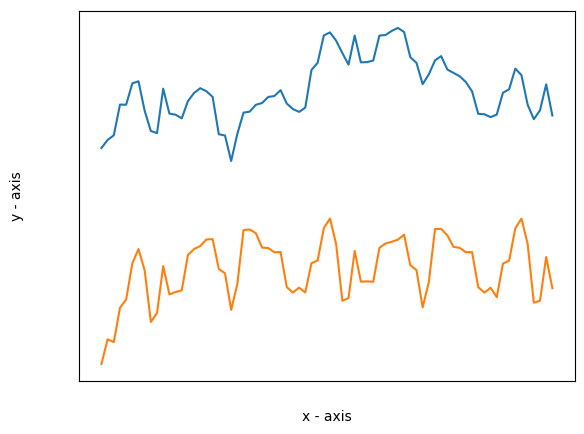

129587 Magnetism easy predicted acc - 99.28130340576172 -- real acc 99.58149021009424




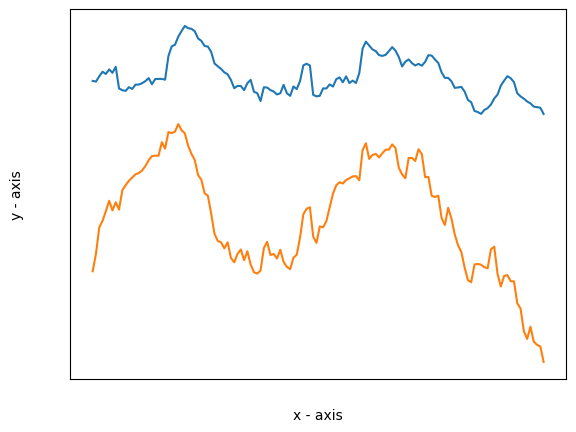

129454 Magnetism normal predicted acc - 98.87750244140625 -- real acc 99.15181902195944




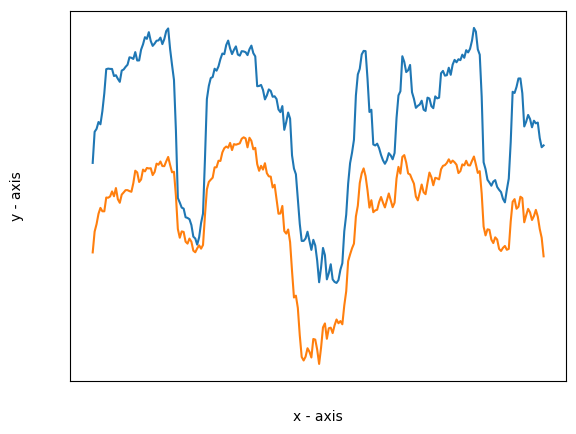

129470 Magnetism hard predicted acc - 98.40956115722656 -- real acc 98.31969596890386




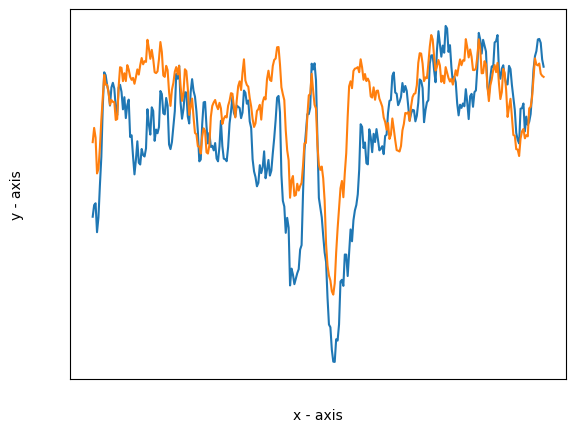

129449 Magnetism expert+ predicted acc - 97.16470336914062 -- real acc 96.78207551413654




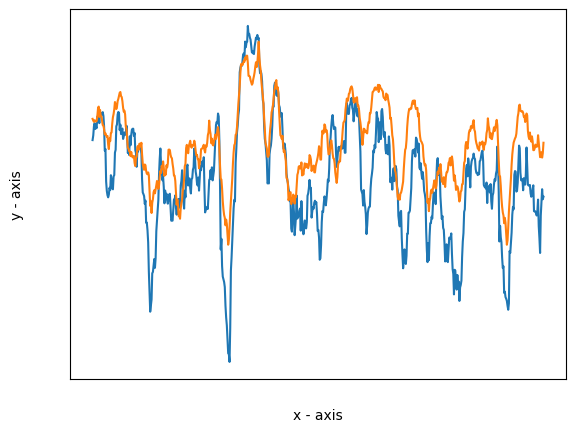

280301 sacrament ex+ predicted acc - 96.48802185058594 -- real acc 96.18013394476559




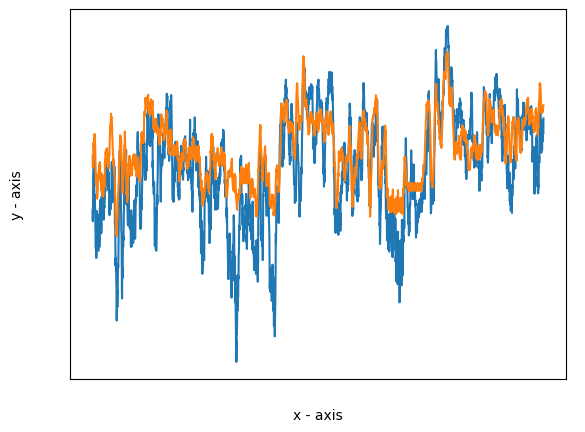

304958 rotten ex+ predicted acc - 96.71294403076172 -- real acc 96.48923807317394




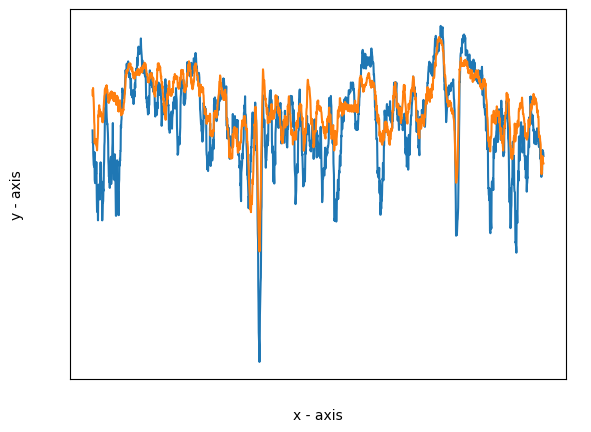

212829 melan stroller ex+ predicted acc - 96.62444305419922 -- real acc 96.2201767372748




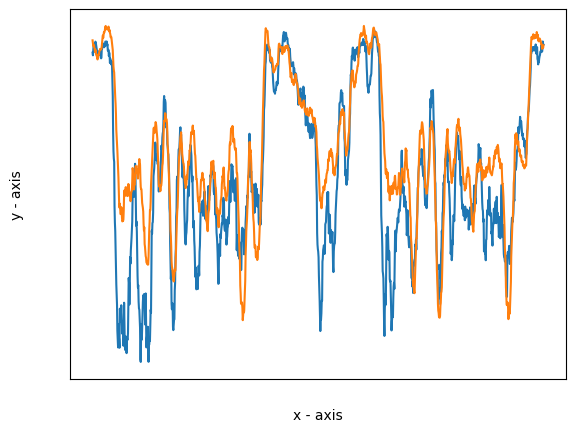

In [23]:
import matplotlib.pyplot as plt
import time

hmm = [
        ["287692", "Watch me dance easy"],
        ["129587", "Magnetism easy"],
        ["129454", "Magnetism normal"],
        ["129470", "Magnetism hard"],
        ["129450", "Magnetism expert"],
        ["129449", "Magnetism expert+"],
        ["280301", "sacrament ex+"],
        ["304958", "rotten ex+"],
        ["212829", "melan stroller ex+"],
        ["219625", "toromi 2 ex+"],
        ["297487", "ludicrous ex+"]]
    # hmm = ["86346", "86338"]
    # for val_data_this in val_data:
for val_data_this, map_name in hmm:
    val_xx, val_yy = generate_data_sync([val_data_this], [1], True)
    if len(val_xx) == 0:
        continue

    acc = []
    acc_real = []
    
    speeds = [[], [], []]
    speeds_real = [[], [], []]
    
    complexities = []
    complexities_real = []

    for batch_pred, batch_inp in zip(model(val_xx), val_yy):
        for pred, inp in zip(batch_pred, batch_inp):
            if inp == 0.0:
                continue
            
            acc.append(pred[0])
            acc_real.append(inp)
            
            # for i in range(3):
            #     speeds[i].append(pred[i+1])
            #     speeds_real[i].append(inp[i+1])
            
            # complexities.append(pred[1]*(1-pred[0]))
            # complexities_real.append(inp[1]*(1-inp[0]))


    print(f"{val_data_this} {map_name} predicted acc - {(sum(acc)/len(acc)*15+100)/1.15} -- real acc {(sum(acc_real)/len(acc_real)*15+100)/1.15}")
    # for i in range(3):
    #     print(f"{val_data_this} speed - {sum(speeds[i])/len(speeds[i])} -- {sum(speeds_real[i])/len(speeds_real[i])}")
    # print(f"{val_data_this} complexity - {sum(complexities)/len(complexities)} -- {sum(complexities_real)/len(complexities_real)}")
    
    print("")
    print("")
    
    # complexities = np.convolve(complexities, np.ones(30)/30, mode='valid')
    # speed = np.convolve(speed, np.ones(30)/30, mode='valid')
    # acc = np.convolve([(acc_*15+100)/115 for acc_ in acc], np.ones(30)/30, mode='valid')
    acc_real = np.convolve(acc_real, np.ones(15)/15, mode='valid')
    x = [i for i in range(len(acc_real))]
    plt.plot(x, acc_real)
    acc = np.convolve(acc, np.ones(15)/15, mode='valid')
    x = [i for i in range(len(acc))]
    plt.plot(x, acc)
    
    # plt.plot(x, complexities)
    # for i in range(3):
    #     plt.plot(x, np.convolve(speeds[i], np.ones(30)/30, mode='valid'))
    plt.xlabel('x - axis')
    plt.ylabel('y - axis')
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.show()